# Segmentación de Clientes con Segmentación Manual

En este notebook se utiliza una base de datos de e-commerce para segmentar clientes de forma manual a partir de las métricas calculadas en el análisis:

- **Total Revenue**: Ingreso total por cliente.
- **Total Units**: Cantidad total de productos comprados.
- **NumCategories**: Número de categorías (diversidad de productos) compradas.

Además, se agrupa la variable numérica **age** con pd.cut para ver cómo se distribuyen las compras en función de grupos etarios.

El objetivo es definir segmentos (por ejemplo, "Bajo", "Medio" y "Alto" en Total Revenue) que sirvan para orientar estrategias de negocio, sin utilizar algoritmos de clustering complejos.

In [1]:
!wget https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/customer_shopping_data.csv.zip
!unzip customer_shopping_data.csv.zip

--2025-03-27 21:04:32--  https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/customer_shopping_data.csv.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/customer_shopping_data.csv.zip [following]
--2025-03-27 21:04:32--  https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/customer_shopping_data.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1712272 (1.6M) [application/zip]
Saving to: ‘customer_shopping_data.csv.zip’

cus

In [2]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
%matplotlib inline
sns.set(style='whitegrid')

## 1. Carga y Preprocesamiento de Datos

Utilizamos una base de datos sintética basada en la siguiente estructura:

- **invoice_no**
- **customer_id**
- **gender**
- **age**
- **category**
- **quantity**
- **price**
- **payment_method**
- **invoice_date**
- **shopping_mall**

Se convierte la fecha a datetime y se calcula la métrica *Revenue* (quantity * price).

In [3]:
# Crear DataFrame con datos de ejemplo
df = pd.read_csv('customer_shopping_data.csv')


In [4]:

# Convertir invoice_date a datetime
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='%d/%m/%Y')

# Calcular Revenue
df['Revenue'] = df['quantity'] * df['price']

print('Datos transaccionales:')
df

Datos transaccionales:


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,Revenue
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,7502.00
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,5401.53
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,300.08
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,15004.25
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,242.40
...,...,...,...,...,...,...,...,...,...,...,...
99452,I219422,C441542,Female,45,Souvenir,5,58.65,Credit Card,2022-09-21,Kanyon,293.25
99453,I325143,C569580,Male,27,Food & Beverage,2,10.46,Cash,2021-09-22,Forum Istanbul,20.92
99454,I824010,C103292,Male,63,Food & Beverage,2,10.46,Debit Card,2021-03-28,Metrocity,20.92
99455,I702964,C800631,Male,56,Technology,4,4200.00,Cash,2021-03-16,Istinye Park,16800.00


## 2. Análisis Exploratorio

Utilizamos pivot tables y crosstabs para explorar la distribución de ingresos y transacciones por diferentes dimensiones.

In [5]:
print("\nResumen de los datos:")
print(df.describe())
print("\nDistribución de género:")
print(df['gender'].value_counts())


Resumen de los datos:
                age      quantity         price                invoice_date  \
count  99457.000000  99457.000000  99457.000000                       99457   
mean      43.427089      3.003429    689.256321  2022-02-04 02:46:59.783424   
min       18.000000      1.000000      5.230000         2021-01-01 00:00:00   
25%       30.000000      2.000000     45.450000         2021-07-19 00:00:00   
50%       43.000000      3.000000    203.300000         2022-02-05 00:00:00   
75%       56.000000      4.000000   1200.320000         2022-08-22 00:00:00   
max       69.000000      5.000000   5250.000000         2023-03-08 00:00:00   
std       14.990054      1.413025    941.184567                         NaN   

            Revenue  
count  99457.000000  
mean    2528.789268  
min        5.230000  
25%      136.350000  
50%      600.170000  
75%     2700.720000  
max    26250.000000  
std     4222.475781  

Distribución de género:
gender
Female    59482
Male      39975
Nam

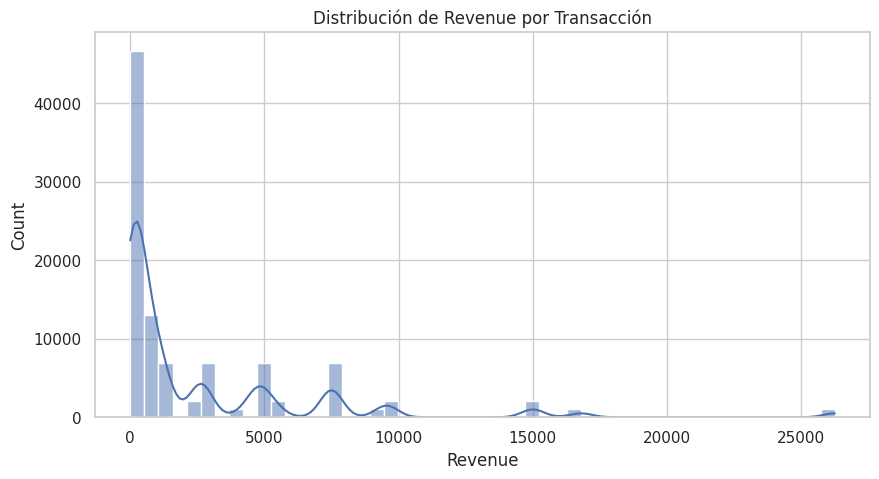

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(df['Revenue'], bins=50, kde=True)
plt.title('Distribución de Revenue por Transacción')
plt.show()

## 3. Agregación a Nivel de Cliente

Agrupamos las transacciones por **customer_id** y **category** para obtener la cantidad total de cada producto comprado por cliente.

In [15]:
customer_summary = df.groupby('customer_id').agg(
    Total_Revenue=('Revenue', 'sum'),
    Total_Units=('quantity', 'sum'),
    NumCategories=('category', 'nunique')
).reset_index()

print(customer_summary.head())

  customer_id  Total_Revenue  Total_Units  NumCategories
0     C100004        7502.00            5              1
1     C100005        2400.68            2              1
2     C100006         322.56            3              1
3     C100012         130.75            5              1
4     C100019          35.84            1              1


### Crear tabla a nivel de cliente (formato ancho)

Convertimos la tabla agrupada en un formato ancho: cada fila es un cliente y cada columna es una categoría. Esto facilita el análisis comparativo.

In [16]:
customer_category = df.pivot_table(index='customer_id', columns='category', values='quantity', aggfunc='sum', fill_value=0)
print(customer_category.head())

category     Books  Clothing  Cosmetics  Food & Beverage  Shoes  Souvenir  \
customer_id                                                                 
C100004          0         5          0                0      0         0   
C100005          0         0          0                0      2         0   
C100006          0         0          0                0      0         0   
C100012          0         0          0                5      0         0   
C100019          0         0          0                0      0         0   

category     Technology  Toys  
customer_id                    
C100004               0     0  
C100005               0     0  
C100006               0     3  
C100012               0     0  
C100019               0     1  


## 4. Transformación con Melt: Formato Largo

Convertimos la tabla ancha a formato largo para obtener un DataFrame con tres columnas: `customer_id`, `category` y `quantity`. Este formato es útil para visualizar la distribución de compras por cliente.

  customer_id category  quantity
0     C100004    Books         0
1     C100005    Books         0
2     C100006    Books         0
3     C100012    Books         0
4     C100019    Books         0


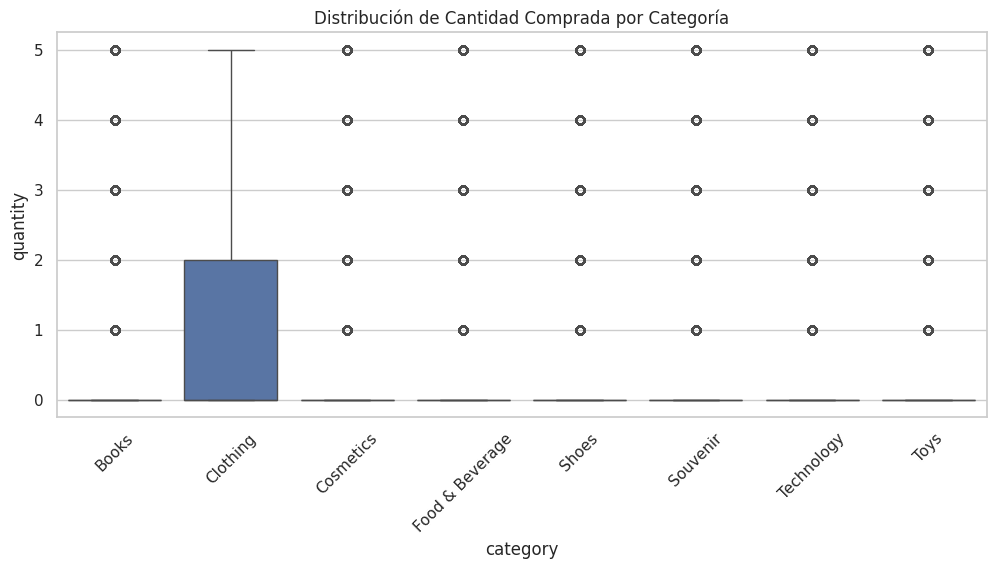

In [21]:
customer_long = customer_category.reset_index().melt(
    id_vars=['customer_id'],  # Mantener el identificador del cliente
    var_name='category',      # Nombre de la columna de categorías
    value_name='quantity'     # Nombre de la columna de valores
)
print(customer_long.head())
plt.figure(figsize=(12, 5))
sns.boxplot(x='category', y='quantity', data=customer_long)
plt.xticks(rotation=45)
plt.title('Distribución de Cantidad Comprada por Categoría')
plt.show()

## 5. Segmentación Manual usando pd.cut

Utilizaremos pd.cut para segmentar a los clientes en función de su **Total Revenue**. Definiremos 3 grupos:

- **Bajo**: Clientes con ingresos bajos.
- **Medio**: Clientes con ingresos moderados.
- **Alto**: Clientes con altos ingresos.

Calculamos las métricas a nivel de cliente y aplicamos pd.cut para crear la variable *RevenueSegment*.

Además, agrupamos la variable **age** en intervalos para ver la distribución de segmentos por grupo etario.

In [27]:
bins = [0, 1000, 5000, customer_summary['Total_Revenue'].max()]
labels = ['Bajo', 'Medio', 'Alto']
customer_summary['RevenueSegment'] = pd.cut(customer_summary['Total_Revenue'], bins=bins, labels=labels, include_lowest=True)


Además, agrupamos la edad en intervalos para complementar la segmentación.

In [28]:
age_bins = [18, 30, 45, 60, 70]
age_labels = ['Joven', 'Adulto Joven', 'Adulto', 'Mayor']
df['AgeGroup'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, include_lowest=True)
print(customer_summary[['customer_id', 'Total_Revenue', 'RevenueSegment']].head())

  customer_id  Total_Revenue RevenueSegment
0     C100004        7502.00           Alto
1     C100005        2400.68          Medio
2     C100006         322.56           Bajo
3     C100012         130.75           Bajo
4     C100019          35.84           Bajo


## 6. Visualización Final de la Segmentación

Mostramos una gráfica de barras que resuma la cantidad de clientes en cada segmento de ingresos (*RevenueSegment*). Esta visualización permite identificar de forma rápida qué grupo es el predominante.

<ipython-input-29-23d17e3a9357>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=customer_summary['RevenueSegment'], palette="Blues")


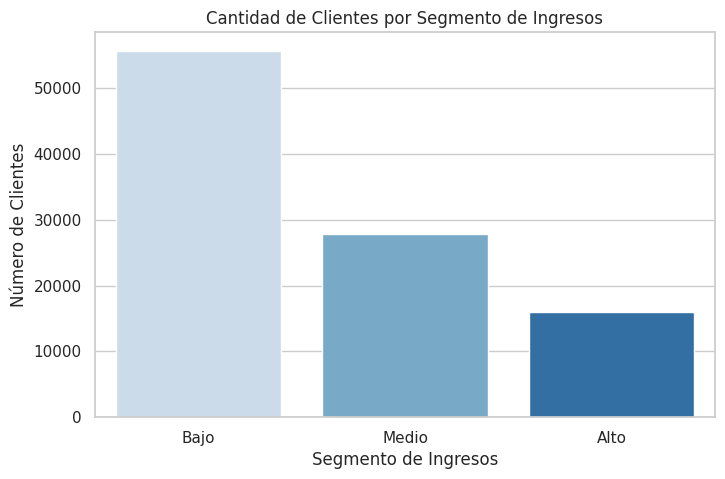

RevenueSegment   Bajo  Medio  Alto
AgeGroup                          
Joven           14014   6946  4064
Adulto Joven    16143   8080  4607
Adulto          15905   8012  4517
Mayor            9608   4753  2808


In [29]:
plt.figure(figsize=(8, 5))
sns.countplot(x=customer_summary['RevenueSegment'], palette="Blues")
plt.title('Cantidad de Clientes por Segmento de Ingresos')
plt.xlabel('Segmento de Ingresos')
plt.ylabel('Número de Clientes')
plt.show()
age_revenue_crosstab = pd.crosstab(df['AgeGroup'], customer_summary['RevenueSegment'])
print(age_revenue_crosstab)

## 7. Conclusiones y Siguientes Pasos

### Insights Obtenidos:

- La segmentación manual usando **pd.cut** permite clasificar a los clientes según su ingreso total, lo que puede ayudar a identificar clientes de alto valor para campañas de fidelización.
- La crosstab entre grupos de edad y segmentos de ingresos revela cómo varían los patrones de compra en función de la edad.

### Siguientes Pasos:

1. Profundizar en cada segmento analizando otros comportamientos (por ejemplo, diversidad de categorías y métodos de pago).
2. Diseñar estrategias de marketing específicas para cada segmento.
3. Integrar estos insights en dashboards interactivos para monitoreo en tiempo real.

Con este flujo de trabajo se demuestra cómo, sin necesidad de algoritmos avanzados, se puede segmentar a los clientes usando reglas definidas y herramientas de transformación de datos en **pandas**. ¡Éxito en tu análisis!